#**Experiment two:**
For this experiment, we adress the following research questions

How does performance depend on the sentence length? Compare the various models. Is there a model that does better on longer sentences? If so, why?

To address both questions we run the models: DeepBOW, LSTM, Tree-LSTM and the supervised Tree-LSTM and compare their accuracies. We test them over 3 seeds to get the best models and mean accuracy on the test set.


## Preparing the data

Let's first download the data set and take a look.

In [1]:
import re
import random
import time
import math
import numpy as np
import nltk
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('default')

In [2]:
!wget http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
!unzip trainDevTestTrees_PTB.zip

--2024-12-12 19:28:33--  http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip [following]
--2024-12-12 19:28:34--  https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789539 (771K) [application/zip]
Saving to: ‘trainDevTestTrees_PTB.zip’

trainDevTestTrees_P 100%[===================>] 771.03K  3.48MB/s    in 0.2s    

2024-12-12 19:28:34 (3.48 MB/s) - ‘trainDevTestTrees_PTB.zip’ saved [789539/789539]

Archive:  trainDevTestTrees_PTB.zip
   creating: trees/
  inflating: trees/dev.txt           
  inflating: trees/test.txt          
  inflating: trees/train.txt         


In [3]:
# this function reads in a textfile and fixes an issue with "\\"
def filereader(path):
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

Let's look at a data point. It is a **flattened binary tree**, with sentiment scores at every node, and words as the leaves (or *terminal nodes*).

In [4]:
s = next(filereader("trees/dev.txt"))
print(s)

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))


In [5]:
# We can use NLTK to better visualise the tree structure of the sentence
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

<ipython-input-5-6ab7e95feba4>:5: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(tree))


The sentiment scores range from 0 (very negative) to 5 (very positive). Again, as you can see, every node in the tree is labeled with a sentiment score. For now, we will only use the score at the **root node**, i.e., the sentiment score for the complete sentence.

In [6]:
# Let's first make a function that extracts the tokens (the leaves).

def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()

# let's try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
13


> *Warning: you could also parse a treestring using NLTK and ask it to return the leaves, but there seems to be an issue with NLTK not always correctly parsing the input, so do not rely on it.*

In [7]:
# We will also need the following function, but you can ignore this for now.
# It is explained later on.

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

In [8]:
# Now let's first see how large our data sets are.
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

trees/train.txt  8544
trees/dev.txt    1101
trees/test.txt   2210


In [9]:
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
    print(f"First sentence in {path}:")
    print(next(filereader(path)))


First sentence in trees/train.txt:
(3 (2 (2 The) (2 Rock)) (4 (3 (2 is) (4 (2 destined) (2 (2 (2 (2 (2 to) (2 (2 be) (2 (2 the) (2 (2 21st) (2 (2 (2 Century) (2 's)) (2 (3 new) (2 (2 ``) (2 Conan)))))))) (2 '')) (2 and)) (3 (2 that) (3 (2 he) (3 (2 's) (3 (2 going) (3 (2 to) (4 (3 (2 make) (3 (3 (2 a) (3 splash)) (2 (2 even) (3 greater)))) (2 (2 than) (2 (2 (2 (2 (1 (2 Arnold) (2 Schwarzenegger)) (2 ,)) (2 (2 Jean-Claud) (2 (2 Van) (2 Damme)))) (2 or)) (2 (2 Steven) (2 Segal))))))))))))) (2 .)))
First sentence in trees/dev.txt:
(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
First sentence in trees/test.txt:
(2 (3 (3 Effective) (2 but)) (1 (1 too-tepid) (2 biopic)))


You can see that the number of sentences is not very large. That's probably because the data set required so much manual annotation. However, it is large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment label, and
the transitions (explained later).

In [10]:
from collections import namedtuple
from nltk import Tree

# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])


def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    tree = Tree.fromstring(line)  # use NLTK's Tree
    label = int(line[1])
    trans = transitions_from_treestring(line)
    yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)


# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))
dev_data = list(examplereader("trees/dev.txt", lower=LOWER))
test_data = list(examplereader("trees/test.txt", lower=LOWER))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
dev 1101
test 2210


Let's check out an `Example` object.

#### Vocabulary
A first step in most NLP tasks is collecting all the word types that appear in the data into a vocabulary, and counting the frequency of their occurrences. On the one hand, this will give us an overview of the word distribution of the data set (what are the most frequent words, how many rare words are there, ...). On the other hand, we will also use the vocabulary to map each word to a unique numeric ID, which is a more handy index than a string.

In [11]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).

from collections import Counter, OrderedDict, defaultdict


class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)


class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""

  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1

  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)

  def build(self, min_freq=0):
    '''
    min_freq: minimum number of occurrences for a word to be included
              in the vocabulary
    '''
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)

    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

The vocabulary has by default an `<unk>` token and a `<pad>` token. The `<unk>` token is reserved for all words which do not appear in the training data (and for which, therefore, we cannot learn word representations). The function of the `<pad>` token will be explained later.


Let's build the vocabulary!


In [12]:
# This process should be deterministic and should have the same result
# if run multiple times on the same data set.

v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 18280


Let's have a closer look at the properties of our vocabulary. Having a good idea of what it is like can facilitate data analysis and debugging later on.

In [13]:
# Now let's map the sentiment labels 0-4 to a more readable form
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
print(i2t)
print(i2t[4])

['very negative', 'negative', 'neutral', 'positive', 'very positive']
very positive


In [14]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})
print(t2i)
print(t2i['very positive'])

OrderedDict([('very negative', 0), ('negative', 1), ('neutral', 2), ('positive', 3), ('very positive', 4)])
4


## PyTorch

We are going to need PyTorch and Google Colab does not have it installed by default. Run the cell below to install it.

*For installing PyTorch in your own computer, follow the instructions on [pytorch.org](pytorch.org) instead. This is for Google Colab only.*

In [15]:
import torch
print("Using torch", torch.__version__) # should say 1.7.0+cu101

Using torch 2.5.1+cu121


In [16]:
# Let's also import torch.nn, a PyTorch package that
# makes building neural networks more convenient.
from torch import nn

In [17]:
# PyTorch can run on CPU or on Nvidia GPU (video card) using CUDA
# This cell selects the GPU if one is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
# Seed manually to make runs reproducible
# You need to set this again if you do multiple runs of the same model
torch.manual_seed(42)

# When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

> **Hey, wait, where is the bias vector?**
> PyTorch does not print Parameters, only Modules!

> We can print it ourselves though, to check that it is there.

In [19]:

# Here we print each parameter name, shape, and if it is trainable.
def print_parameters(model):
  total = 0
  for name, p in model.named_parameters():
    total += np.prod(p.shape)
    print("{:24s} {:12s} requires_grad={}".format(name, str(list(p.shape)), p.requires_grad))
  print("\nTotal number of parameters: {}\n".format(total))


#print_parameters(bow_model)

#### Preparing an example for input

To feed sentences to our PyTorch model, we need to convert a sequence of tokens to a sequence of IDs. The `prepare_example` function below takes care of this for us. We then use these IDs as indices for the word embedding table.

In [20]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for a single example
  """

  # vocab returns 0 if the word is not there (i2w[0] = <unk>)
  x = [vocab.w2i.get(t, 0) for t in example.tokens]

  x = torch.LongTensor([x])
  x = x.to(device)

  y = torch.LongTensor([example.label])
  y = y.to(device)

  return x, y

In [21]:
x, y = prepare_example(dev_data[0], v)
print('x:', x)
print('y:', y)

x: tensor([[  28,    9,    6,  998,   16,   18,  998,  135,   32, 7688,    5,    0,
            2]], device='cuda:0')
y: tensor([3], device='cuda:0')


#### Evaluation
We now need to define an evaluation metric.
How many predictions do we get right? The accuracy will tell us.
Make sure that you understand this code block.


In [22]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
  """Accuracy of a model on given data set."""
  correct = 0
  total = 0
  model.eval()  # disable dropout (explained later)

  for example in data:

    # convert the example input and label to PyTorch tensors
    x, target = prep_fn(example, model.vocab)

    # forward pass without backpropagation (no_grad)
    # get the output from the neural network for input x
    with torch.no_grad():
      logits = model(x)

    # get the prediction
    prediction = logits.argmax(dim=-1)

    # add the number of correct predictions to the total correct
    correct += (prediction == target).sum().item()
    total += 1

  return correct, total, correct / float(total)

We are using accuracy as a handy evaluation metric. Please consider using [alternative metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for your experiments if that makes more theoretical sense.

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

Shuffling is optional so that we get to use this function to get validation and test examples, too.

In [23]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  for example in data:
    yield example

#### Exercise: Training function

Your task is now to complete the training loop below.
Before you do so, please read the section about optimisation.

**Optimisation**

As mentioned in the "Intro to PyTorch" notebook, one of the perks of using PyTorch is automatic differentiation. We will use it to train our BOW model.

We train our model by feeding it an input, performing a **forward** pass, obtaining an output prediction, and calculating a **loss** with our loss function.
After the gradients are computed in the **backward** pass, we can take a step on the surface of the loss function towards more optimal parameter settings (gradient descent).

The package we will use to do this optimisation is [torch.optim](https://pytorch.org/docs/stable/optim.html).

In [24]:
from torch import optim

Besides implementations of stochastic gradient descent (SGD), this package also implements the optimisation algorithm Adam, which we'll be using in this practical.
For the purposes of this assignment you do not need to know what Adam does besides that it uses gradient information to update our model parameters by calling:

```
optimizer.step()
```
Remember when we updated our parameters in the PyTorch tutorial in a loop?


```python
# update weights
learning_rate = 0.5
for f in net.parameters():
    # for each parameter, take a small step in the opposite dir of the gradient
    p.data = p.data - p.grad.data * learning_rate

```
The function call optimizer.step() does effectively the same thing.

*(If you want to know more about optimisation algorithms using gradient information, [this blog](http://ruder.io/optimizing-gradient-descent/.) gives a nice intuitive overview.)*

In [25]:
def train_model(model, optimizer, num_iterations=10000,
                print_every=1000, eval_every=1000,
                batch_fn=get_examples,
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=1, eval_batch_size=None):
  """Train a model."""
  training_data = train_data[:]
  iter_i = 0
  train_loss = 0.
  print_num = 0
  start = time.time()
  criterion = nn.CrossEntropyLoss() # loss function
  best_eval = 0.
  best_iter = 0

  # store train loss and validation accuracy during training
  # so we can plot them afterwards
  losses = []
  accuracies = []

  if eval_batch_size is None:
    eval_batch_size = batch_size

  while True:  # when we run out of examples, shuffle and continue
    for batch in batch_fn(train_data, batch_size=batch_size):

      # forward pass
      model.train()
      x, targets = prep_fn(batch, model.vocab)
      logits = model(x)

      B = targets.size(0)  # later we will use B examples per update

      # compute cross-entropy loss (our criterion)
      # note that the cross entropy loss function computes the softmax for us
      loss = criterion(logits.view([B, -1]), targets.view(-1))
      train_loss += loss.item()

      # backward pass (tip: check the Introduction to PyTorch notebook)

      # erase previous gradients
      optimizer.zero_grad()

      # compute gradients
      loss.backward()

      # update weights - take a small step in the opposite dir of the gradient
      optimizer.step()


      print_num += 1
      iter_i += 1

      # print info
      if iter_i % print_every == 0:
        print("Iter %r: loss=%.4f, time=%.2fs" %
              (iter_i, train_loss, time.time()-start))
        losses.append(train_loss)
        print_num = 0
        train_loss = 0.

      # evaluate
      if iter_i % eval_every == 0:
        _, _, accuracy = eval_fn(model, dev_data, batch_size=eval_batch_size,
                                 batch_fn=batch_fn, prep_fn=prep_fn)
        accuracies.append(accuracy)
        print("iter %r: dev acc=%.4f" % (iter_i, accuracy))

        # save best model parameters
        if accuracy > best_eval:
          print("new highscore")
          best_eval = accuracy
          best_iter = iter_i
          path = "{}.pt".format(model.__class__.__name__)
          ckpt = {
              "state_dict": model.state_dict(),
              "optimizer_state_dict": optimizer.state_dict(),
              "best_eval": best_eval,
              "best_iter": best_iter
          }
          torch.save(ckpt, path)

      # done training
      if iter_i == num_iterations:
        print("Done training")

        # evaluate on train, dev, and test with best model
        print("Loading best model")
        path = "{}.pt".format(model.__class__.__name__)
        ckpt = torch.load(path)
        model.load_state_dict(ckpt["state_dict"])

        _, _, train_acc = eval_fn(
            model, train_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, dev_acc = eval_fn(
            model, dev_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, test_acc = eval_fn(
            model, test_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)

        print("best model iter {:d}: "
              "train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
                  best_iter, train_acc, dev_acc, test_acc))

        return losses, accuracies, test_acc

Please note that we set the number of iterations to 30K as an indicative value, after which we simply stop training without checking for convergence. You should choose an appropriate number of iterations and motivate your decision. **This holds for all pre-set numbers of iteration in the following code blocks.**

# CBOW

We now continue with a **continuous bag-of-words (CBOW)** model. (*This is not the same as the word2vec CBOW model!*)

It is similar to the BOW model above, but now embeddings can have a dimension of *arbitrary size*.
This means that we can choose a higher dimensionality and learn more aspects of each word. We will still sum word vectors to get a sentence representation, but now the size of the resulting vector will no longer correspond to the number of sentiment classes.

So to turn the size of our summed vector into the number of output classes, we can *learn* a parameter matrix $W$ and multiply it by the sum vector $x$: $$Wx$$
If the size of $x$ is `d x 1`, we can set $W$ to be `5 x d`, so that the output of the matrix multiplication will be the of the desired size, `5 x 1`. Then, just like for the BOW model, we can obtain a prediction using the argmax function.

## Exercise: implement and train the CBOW model

Write a class `CBOW` that:

- has word embeddings with size 300
- sums the word vectors for the input words (just like in `BOW`)
- projects the resulting vector down to 5 units using a linear layer and a bias term (check out `nn.Linear`)

Train your CBOW model and plot the validation accuracy and training loss over time.

In [26]:
import torch
import torch.nn as nn

class CBOW(nn.Module):
    def __init__(self, vocab_size, num_classes, vocab, embedding_dim=300):
        """
        CBOW Model
        """
        super(CBOW, self).__init__()

        # 1. Embedding layer: maps word indices to 300-dimensional vectors
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        # 2. Linear layer: projects the sentence vector (embedding_dim) to output logits (num_classes)
        self.fc = nn.Linear(embedding_dim, num_classes)

        self.vocab = vocab

    def forward(self, x):
        """
        Forward pass of the CBOW model
        """
        # 1. Look up embeddings for each word in the input
        embeddings = self.embed(x)  # Shape: [batch_size, seq_len, embedding_dim]

        # 2. Sum embeddings along the sequence length dimension
        sentence_vector = embeddings.sum(dim=1)  # Shape: [batch_size, embedding_dim]

        # 3. Project the sentence vector to logits using the linear layer
        logits = self.fc(sentence_vector)  # Shape: [batch_size, num_classes]

        return logits

In [27]:
print("Is GPU available? ", torch.cuda.is_available())

Is GPU available?  True


In [28]:
# # If everything is in place we can now train our first model!
# cbow_model = CBOW(len(v.w2i), len(t2i), vocab=v)
# print(cbow_model)

# cbow_model = cbow_model.to(device)

# optimizer = optim.Adam(cbow_model.parameters(), lr=0.0005)

# cbow_losses, cbow_accuracies = train_model(
#     cbow_model, optimizer, num_iterations=1000,
#     print_every=100, eval_every=100)

In [29]:
# This will plot the validation accuracies across time.
# plt.plot(cbow_accuracies)

In [30]:
# This will plot the validation accuracies across time.
# plt.plot(cbow_losses)

# Deep CBOW

To see if we can squeeze some more performance out of the CBOW model, we can make it deeper and non-linear by adding more layers and, e.g., tanh-activations.
By using more parameters we can learn more aspects of the data, and by using more layers and non-linearities, we can try to learn a more complex function.
This is not something that always works. If the input-output mapping of your data is simple, then a complicated function could easily overfit on your training set, thereby leading to poor generalization.

#### Exercise: write Deep CBOW class and train it

Write a class `DeepCBOW`.

In your code, make sure that your `output_layer` consists of the following:
- A linear transformation from E units to D units.
- A Tanh activation
- A linear transformation from D units to D units
- A Tanh activation
- A linear transformation from D units to 5 units (our output classes).

E is the size of the word embeddings (please use E=300) and D for the size of a hidden layer (please use D=100).

We recommend using [nn.Sequential](https://pytorch.org/docs/stable/nn.html?highlight=sequential#torch.nn.Sequential) to implement this exercise.

In [31]:
import torch
import torch.nn as nn

class DeepCBOW(nn.Module):
    def __init__(self, vocab_size, vocab, num_classes, embedding_dim=300, hidden_dim=100):
        """
        Deep CBOW Model
        :param vocab_size: Size of the vocabulary
        :param num_classes: Number of output classes
        :param embedding_dim: Size of the word embeddings (E)
        :param hidden_dim: Size of the hidden layers (D)
        """
        super(DeepCBOW, self).__init__()

        # Embedding layer: Map word indices to embedding vectors
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        # Output layer: Stack of linear layers + tanh activations
        self.output_layer = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),  # E -> D
            nn.Tanh(),                            # Non-linearity
            nn.Linear(hidden_dim, hidden_dim),    # D -> D
            nn.Tanh(),                            # Non-linearity
            nn.Linear(hidden_dim, num_classes)    # D -> 5
        )

    def forward(self, x):
        """
        Forward pass of the Deep CBOW model
        :param x: Input word indices (batch_size, seq_len)
        :return: Logits (batch_size, num_classes)
        """
        # 1. Look up embeddings for each word in the input
        embeddings = self.embed(x)  # Shape: [batch_size, seq_len, embedding_dim]

        # 2. Sum embeddings along the sequence length dimension
        sentence_vector = embeddings.sum(dim=1)  # Shape: [batch_size, embedding_dim]

        # 3. Pass through the output layer
        logits = self.output_layer(sentence_vector)  # Shape: [batch_size, num_classes]

        return logits


# Pre-trained word embeddings

In [32]:
import requests

url = "https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt"

# File name to save the downloaded file
file_name = "glove.filtered.txt"

# Download the file
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses

# Save the file content
with open(file_name, "wb") as f: # wb mode for writing binary data
    f.write(response.content)

print(f"File downloaded and saved as {file_name}")

File downloaded and saved as glove.filtered.txt


In [33]:
# Exercise: Print the first 4 lines of the files that you downloaded.
# What do you see?
# Print the first few lines of the file
with open("glove.filtered.txt", "r", encoding="utf-8") as f:
    for i in range(5):  # Adjust the number if needed
        (f.readline().strip())


In [34]:
# Parse the Word2Vec file
glove = {}
with open(file_name, "r", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]  # The first value is the word
        vector = [float(x) for x in values[1:]]  # The rest are the embedding values
        glove[word] = vector

print(f"Loaded {len(glove)} word embeddings!")


from collections import defaultdict
import numpy as np

# Initialize vocabulary object
v = Vocabulary()

# Add special tokens manually
v.add_token("<unk>")
v.add_token("<pad>")

# Define embedding dimensions and initialize list for vectors
embedding_dim = 300  # Update if using different dimensions
vectors = []

# Add special token embeddings
vectors.append(np.random.uniform(-0.01, 0.01, embedding_dim))  # <unk>
vectors.append(np.zeros(embedding_dim))  # <pad>

# Add pre-trained word embeddings to vocabulary
for word, vector in glove.items():
    if word not in v.w2i:  # If the word is not already in the vocab
        v.add_token(word)
        vectors.append(vector)

# Convert vectors to a NumPy array
vectors = np.stack(vectors, axis=0)

# Print vocabulary size and first few entries
print(f"Vocabulary size: {len(v.w2i)}")
print("First 10 vocabulary entries:")
for i, word in enumerate(v.i2w[:10]):
    print(f"{i}: {word}")


Loaded 20725 word embeddings!
Vocabulary size: 20727
First 10 vocabulary entries:
0: <unk>
1: <pad>
2: ,
3: .
4: the
5: and
6: to
7: of
8: a
9: in


# Create and Evaluate bins

In [35]:
def create_bins(dataset, vocab, window_size=5, max_length=45):
    """
    Create sliding window bins with custom window size and maximum length.
    """
    # Create sliding window bins
    bins = [(max(0, i - window_size // 2), min(max_length, i + window_size // 2))
            for i in range(0, max_length + 1)]

    # Initialize dictionary for bins
    binned_data = {f"{low}-{high}": [] for low, high in bins}

    for example in dataset:
        # Convert tokens to IDs and compute sentence length
        x, y = prepare_example(example, vocab)
        sentence_length = x.size(1)

        # Place the example into the correct sliding window bin
        for low, high in bins:
            if low <= sentence_length <= high:
                binned_data[f"{low}-{high}"].append((x, y))
                break

    return binned_data


In [36]:
def create_bins(dataset, vocab, window_size=5, max_length=45):
    """
    Create sliding window bins with custom window size and maximum length.
    Includes a special bin for sentence lengths 35 and up.
    """
    # Create sliding window bins, excluding the last bin for 35 and up
    bins = [(max(0, i - window_size // 2), min(max_length, i + window_size // 2))
            for i in range(0, max_length)]  # Bins for sentences < 35

    # Initialize dictionary for bins
    binned_data = {f"{low}-{high}": [] for low, high in bins}

    for example in dataset:
        # Convert tokens to IDs and compute sentence length
        x, y = prepare_example(example, vocab)
        sentence_length = x.size(1)

        # Place the example into the correct bin
        for low, high in bins:
            if low <= sentence_length <= high:
                binned_data[f"{low}-{high}"].append((x, y))
                break

    return binned_data


In [37]:
def evaluate_on_bins(model, binned_data, eval_fn, verbose=True):
    """
    Evaluate the model on each bin of sentence lengths.
    """
    model.eval()
    bin_results = {}

    for bin_range, examples in binned_data.items():
        if not examples:
            bin_results[bin_range] = 0.0
            if verbose:
                print(f"Bin {bin_range}: No examples to evaluate.")
            continue

        all_preds, all_labels = [], []
        for x, y in examples:
            with torch.no_grad():
                logits = model(x)
                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(y.cpu().numpy())

        # Flatten predictions and labels
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        # Compute accuracy instead of using eval_fn
        accuracy = (all_preds == all_labels).mean()

        bin_results[bin_range] = accuracy
        if verbose:
            print(f"Bin {bin_range}: Metric = {accuracy:.4f}")

    return bin_results

#### Exercise: train Deep CBOW with (fixed) pre-trained embeddings

Now train Deep CBOW again using the pre-trained word vectors.


Create a function to set set for reproducbility.

In [38]:
def set_seed(seed):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Enforce determinism in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [39]:
# We define a new class that inherits from DeepCBOW.
class PTDeepCBOW(DeepCBOW):
  def __init__(self, vocab_size, vocab, output_dim, embedding_dim, hidden_dim):
    super(PTDeepCBOW, self).__init__(
        vocab_size, vocab, output_dim, embedding_dim, hidden_dim)
    self.vocab = vocab

In [40]:
seeds = [42, 123, 999]
test_accuracies = []
all_bin_accuracies = {}  # To store bin accuracies across seeds

# Define sliding bins with a window size of 5
window_size = 5
max_length = 45  # Adjust as needed
bins = [(max(0, i - window_size // 2), min(max_length, i + window_size // 2)) for i in range(0, max_length + 1)]
bin_ranges = [f"{low}-{high}" for low, high in bins]

# Prepare structure to track bin accuracies for each seed
for bin_range in bin_ranges:
    all_bin_accuracies[bin_range] = []

for seed in seeds:
    set_seed(seed)

    # Initialize model
    model = PTDeepCBOW(
        vocab_size=len(v.w2i),
        vocab=v,
        embedding_dim=300,
        hidden_dim=100,
        output_dim=5
    ).to(device)
    model.embed.weight.data.copy_(torch.from_numpy(vectors))
    model.embed.weight.requires_grad = False  # Freeze pre-trained embeddings

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    # Train model
    losses, accuracies, test_acc = train_model(
        model=model,
        optimizer=optimizer,
        num_iterations=3240,  # Number of training iterations
        print_every=250,      # Print loss every 1000 iterations
        eval_every=250,       # Evaluate on validation set every 1000 iterations
        batch_fn=get_examples, # Your batch generation function
        prep_fn=prepare_example,
        eval_fn=simple_evaluate,
        batch_size=25,         # Training batch size
        eval_batch_size=25     # Validation/test batch size
    )

    # Evaluate on bins
    binned_data = create_bins(test_data, v)
    bin_accuracies = evaluate_on_bins(model, binned_data, eval_fn=simple_evaluate)

    # Store bin accuracies for this seed
    for bin_range, accuracy in bin_accuracies.items():
        if accuracy is not None:
            all_bin_accuracies[bin_range].append(accuracy)

    print(f"Best Test Accuracy for seed {seed}: {test_acc:.4f}")
    test_accuracies.append(test_acc)

# Compute mean and standard deviation across seeds for overall accuracy
mean_accuracy = np.mean(test_accuracies)
std_accuracy = np.std(test_accuracies)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# Compute mean and standard deviation of bin accuracies
print("\nBin-Wise Mean and Standard Deviation Across Seeds:")
for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:  # Skip bins with no data
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)
        print(f"Bin {bin_range}: Mean Accuracy = {mean_bin_acc:.4f}, Std = {std_bin_acc:.4f}")



Shuffling training data
Iter 250: loss=397.7270, time=1.32s
iter 250: dev acc=0.2961
new highscore
Iter 500: loss=377.8989, time=2.23s
iter 500: dev acc=0.2943
Iter 750: loss=370.3613, time=3.01s
iter 750: dev acc=0.3161
new highscore
Iter 1000: loss=360.1955, time=3.84s
iter 1000: dev acc=0.3170
new highscore
Iter 1250: loss=341.0709, time=4.65s
iter 1250: dev acc=0.3524
new highscore
Iter 1500: loss=347.0394, time=5.50s
iter 1500: dev acc=0.4069
new highscore
Iter 1750: loss=326.4417, time=6.42s
iter 1750: dev acc=0.4005
Iter 2000: loss=346.3436, time=7.38s
iter 2000: dev acc=0.3851
Iter 2250: loss=337.0974, time=8.50s
iter 2250: dev acc=0.3542
Iter 2500: loss=330.1880, time=9.29s
iter 2500: dev acc=0.3942
Iter 2750: loss=349.5433, time=10.06s
iter 2750: dev acc=0.4133
new highscore
Iter 3000: loss=346.9627, time=10.89s
iter 3000: dev acc=0.4114
Done training
Loading best model


<ipython-input-25-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 2750: train acc=0.4202, dev acc=0.4133, test acc=0.4240
Bin 0-2: Metric = 0.5000
Bin 0-3: Metric = 0.6923
Bin 0-4: Metric = 0.2000
Bin 1-5: Metric = 0.4545
Bin 2-6: Metric = 0.5088
Bin 3-7: Metric = 0.3731
Bin 4-8: Metric = 0.5204
Bin 5-9: Metric = 0.6119
Bin 6-10: Metric = 0.3803
Bin 7-11: Metric = 0.4848
Bin 8-12: Metric = 0.4359
Bin 9-13: Metric = 0.4941
Bin 10-14: Metric = 0.3671
Bin 11-15: Metric = 0.4194
Bin 12-16: Metric = 0.4533
Bin 13-17: Metric = 0.4316
Bin 14-18: Metric = 0.3689
Bin 15-19: Metric = 0.4505
Bin 16-20: Metric = 0.4217
Bin 17-21: Metric = 0.3243
Bin 18-22: Metric = 0.3793
Bin 19-23: Metric = 0.3226
Bin 20-24: Metric = 0.4125
Bin 21-25: Metric = 0.3788
Bin 22-26: Metric = 0.4308
Bin 23-27: Metric = 0.5588
Bin 24-28: Metric = 0.4286
Bin 25-29: Metric = 0.3654
Bin 26-30: Metric = 0.2941
Bin 27-31: Metric = 0.3421
Bin 28-32: Metric = 0.3667
Bin 29-33: Metric = 0.5789
Bin 30-34: Metric = 0.5652
Bin 31-35: Metric = 0.2778
Bin 32-36: Metric = 0.3000
Bin

In [41]:
# Dictionary to store mean bin accuracies
mean_bin_accuracies_dcbow = {}

# Compute mean and standard deviation of bin accuracies
print("\nBin-Wise Mean and Standard Deviation Across Seeds:")
for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:  # Skip bins with no data
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)

        # Save the mean accuracy into the dictionary
        mean_bin_accuracies_dcbow[bin_range] = mean_bin_acc

        # Print the results
        print(f"Bin {bin_range}: Mean Accuracy = {mean_bin_acc:.4f}, Std = {std_bin_acc:.4f}")

# Now mean_bin_accuracies contains the mean accuracy for each bin range
print("Saved Mean Bin Accuracies:", mean_bin_accuracies_dcbow)



Bin-Wise Mean and Standard Deviation Across Seeds:
Bin 0-2: Mean Accuracy = 0.4444, Std = 0.0786
Bin 0-3: Mean Accuracy = 0.6154, Std = 0.1088
Bin 0-4: Mean Accuracy = 0.2667, Std = 0.0943
Bin 1-5: Mean Accuracy = 0.4444, Std = 0.0143
Bin 2-6: Mean Accuracy = 0.4795, Std = 0.0414
Bin 3-7: Mean Accuracy = 0.3731, Std = 0.0122
Bin 4-8: Mean Accuracy = 0.4830, Std = 0.0293
Bin 5-9: Mean Accuracy = 0.5622, Std = 0.0372
Bin 6-10: Mean Accuracy = 0.3991, Std = 0.0133
Bin 7-11: Mean Accuracy = 0.4495, Std = 0.0258
Bin 8-12: Mean Accuracy = 0.4487, Std = 0.0181
Bin 9-13: Mean Accuracy = 0.4627, Std = 0.0293
Bin 10-14: Mean Accuracy = 0.3586, Std = 0.0119
Bin 11-15: Mean Accuracy = 0.4265, Std = 0.0101
Bin 12-16: Mean Accuracy = 0.4578, Std = 0.0382
Bin 13-17: Mean Accuracy = 0.4526, Std = 0.0172
Bin 14-18: Mean Accuracy = 0.3916, Std = 0.0255
Bin 15-19: Mean Accuracy = 0.4396, Std = 0.0155
Bin 16-20: Mean Accuracy = 0.3936, Std = 0.0205
Bin 17-21: Mean Accuracy = 0.3063, Std = 0.0127
Bin 18-2

# LSTM

#### Exercise: Finish the LSTM cell below.
You will need to implement the LSTM formulas:

$$
\begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o \tanh(c') \\
\end{array}
 $$

where $\sigma$ is the sigmoid function.

*Note that the LSTM formulas can differ slightly between different papers. We use the PyTorch LSTM formulation here.*

In [42]:
class MyLSTMCell(nn.Module):
  """Our own LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(MyLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

# Define weights for input gates
    self.W_ii = nn.Parameter(torch.Tensor(hidden_size, input_size))
    self.W_if = nn.Parameter(torch.Tensor(hidden_size, input_size))
    self.W_ig = nn.Parameter(torch.Tensor(hidden_size, input_size))
    self.W_io = nn.Parameter(torch.Tensor(hidden_size, input_size))

        # Define weights for hidden state gates
    self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_hg = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Define biases
    self.b_i = nn.Parameter(torch.Tensor(hidden_size))
    self.b_f = nn.Parameter(torch.Tensor(hidden_size))
    self.b_g = nn.Parameter(torch.Tensor(hidden_size))
    self.b_o = nn.Parameter(torch.Tensor(hidden_size))


    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, input_, hx, mask=None):
    """
    input is (batch, input_size)
    hx is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h, prev_c = hx

    # Compute the input gate
    i = torch.sigmoid(
            torch.mm(input_, self.W_ii.T) + torch.mm(prev_h, self.W_hi.T) + self.b_i
        )
    # Compute the forget gate
    f = torch.sigmoid(
        torch.mm(input_, self.W_if.T) + torch.mm(prev_h, self.W_hf.T) + self.b_f
    )
    # Compute the candidate cell state
    g = torch.tanh(
        torch.mm(input_, self.W_ig.T) + torch.mm(prev_h, self.W_hg.T) + self.b_g
    )
     # Compute the output gate
    o = torch.sigmoid(
        torch.mm(input_, self.W_io.T) + torch.mm(prev_h, self.W_ho.T) + self.b_o
    )

        # Update the cell state
    c = f * prev_c + i * g

        # Compute the hidden state
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

#### Optional: Efficient Matrix Multiplication

It is more efficient to do a few big matrix multiplications than to do many smaller ones. So we will implement the above cell using just **two** linear layers.

This is possible because the eight linear transformations contained in one forward pass through an LSTM cell can be reduced to just two:
$$W_h h + b_h$$
$$W_i x + b_i $$

with $h = $ `prev_h` and $x = $ `input_`.

and where:

$W_h =  \begin{pmatrix}
W_{hi}\\
W_{hf}\\
W_{hg}\\
W_{ho}
\end{pmatrix}$, $b_h = \begin{pmatrix}
b_{hi}\\
b_{hf}\\
b_{hg}\\
b_{ho}
\end{pmatrix}$,  $W_i = \begin{pmatrix}
W_{ii}\\
W_{if}\\
W_{ig}\\
W_{io}
\end{pmatrix}$ and $b_i = \begin{pmatrix}
b_{ii}\\
b_{if}\\
b_{ig}\\
b_{io}
\end{pmatrix}$.

Convince yourself that, after chunking with [torch.chunk](https://pytorch.org/docs/stable/torch.html?highlight=chunk#torch.chunk), the output of those two linear transformations is equivalent to the output of the eight linear transformations in the LSTM cell calculations above.

#### LSTM Classifier

Having an LSTM cell is not enough: we still need some code that calls it repeatedly, and then makes a prediction from the final hidden state.
You will find that code below. Make sure that you understand it.

In [43]:
class LSTMClassifier(nn.Module):
  """Encodes sentence with an LSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(LSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.rnn = MyLSTMCell(embedding_dim, hidden_dim)

    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),  # explained later
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):

    B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
    T = x.size(1)  # timesteps (the number of words in the sentence)

    input_ = self.embed(x)

    # here we create initial hidden states containing zeros
    # we use a trick here so that, if input is on the GPU, then so are hx and cx
    hx = input_.new_zeros(B, self.rnn.hidden_size)
    cx = input_.new_zeros(B, self.rnn.hidden_size)

    # process input sentences one word/timestep at a time
    # input is batch-major (i.e., batch size is the first dimension)
    # so the first word(s) is (are) input_[:, 0]
    outputs = []
    for i in range(T):
      hx, cx = self.rnn(input_[:, i], (hx, cx))
      outputs.append(hx)

    # if we have a single example, our final LSTM state is the last hx
    if B == 1:
      final = hx
    else:
      #
      # This part is explained in next section, ignore this else-block for now.
      #
      # We processed sentences with different lengths, so some of the sentences
      # had already finished and we have been adding padding inputs to hx.
      # We select the final state based on the length of each sentence.

      # two lines below not needed if using LSTM from pytorch
      outputs = torch.stack(outputs, dim=0)           # [T, B, D]
      outputs = outputs.transpose(0, 1).contiguous()  # [B, T, D]

      # to be super-sure we're not accidentally indexing the wrong state
      # we zero out positions that are invalid
      pad_positions = (x == 1).unsqueeze(-1)

      outputs = outputs.contiguous()
      outputs = outputs.masked_fill_(pad_positions, 0.)

      mask = (x != 1)  # true for valid positions [B, T]
      lengths = mask.sum(dim=1)                 # [B, 1]

      indexes = (lengths - 1) + torch.arange(B, device=x.device, dtype=x.dtype) * T
      final = outputs.view(-1, self.hidden_dim)[indexes]  # [B, D]

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(final)
    return logits

#### Dropout

Data sparsity and a small data set can cause *overfitting*. This is a phenomenom that is very likely to occur when training strong and expressive models, like LSTMs, on small data. In practice, if your model overfits, this means that it will be very good at predicting (or "remembering") the sentiment of the training set, but unable to generalise to new, unseen data in the test set. This is undesirable and one technique to mitigate this issue is *dropout*.

A dropout layer is defined by the following formula, which can be applied, for example, to a linear layer:

$$\text{tanh}(W(\mathbf{h}\odot \mathbf{d}) + \mathbf{b})$$

where $\mathbf{d} \in \{0, 1\}^n$, with $d_j \sim \text{Bernoulli}(p)$,

These formula simply means that we *drop* certain parameters during training (by setting them to zero). Which parameters we drop is stochastically determined by a Bernoulli distribution and the probability of each parameter being dropped is set to $p = 0.5$ in our experiments (see the previous cell of code where we define our output layer). A dropout layer can be applied at many different places in our models. This technique helps against the undesirable effect that a model relies on single parameters for prediction (e.g. if $h^{\prime}_j$ is large, always predict positive). If we use dropout, the model needs to learn to rely on different parameters, which is desirable to obtain better generalisation to unseen data.

**Let's train our LSTM!** Note that is will be a lot slower than previous models because we need to do many more computations per sentence.

#### Training

# Mini-batching



**Why is the LSTM so slow?** Despite our best efforts, we still need to make a lot of matrix multiplications per example (linear in the length of the example) just to get a single classification, and we can only process the 2nd word once we have computed the hidden state for the 1st word (sequential computation).

GPUs are more efficient if we do a few big matrix multiplications, rather than lots of small ones. If we could process multiple examples at the same time, then we could exploit that. That is, we could still process the input sequentially, but doing so for multiple sentences at the same time.

Up to now our "mini-batches" consisted of a single example. This was for a reason: the sentences in our data sets have **different lengths**, and this makes it difficult to process them at the same time.

Consider a batch of 2 sentences:

```
this movie is bad
this movie is super cool !
```

Let's say the IDs for these sentences are:

```
2 3 4 5
2 3 4 6 7 8
```

We cannot feed PyTorch an object with rows of variable length! We need to turn this into a matrix.

The solution is to add **padding values** to our mini-batch:

```
2 3 4 5 1 1
2 3 4 6 7 8
```

Whenever a sentence is shorter than the longest sentence in a mini-batch, we just use a padding value (here: 1) to fill the matrix.

In our computation, we should **ignore** the padding positions (e.g. mask them out) so that paddings do not contribute to the loss.

#### Mini-batch feed
We will now implement a `get_minibatch` function which will replace `get_example` and returns a mini-batch of the requested size.

In [44]:
def get_minibatch(data, batch_size=25, shuffle=True):
  """Return minibatches, optional shuffling"""

  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch

  batch = []

  # yield minibatches
  for example in data:
    batch.append(example)

    if len(batch) == batch_size:
      yield batch
      batch = []

  # in case there is something left
  if len(batch) > 0:
    yield batch

#### Padding function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequence in the minibatch.

In [45]:
def pad(tokens, length, pad_value=1):
  """add padding 1s to a sequence to that it has the desired length"""
  return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New `prepare` function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [46]:
def prepare_minibatch(mb, vocab):
  """
  Minibatch is a list of examples.
  This function converts words to IDs and returns
  torch tensors to be used as input/targets.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  return x, y

In [47]:
# Let's test our new function.
# This should give us 3 examples.
mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))

In [48]:
# We should find padding 1s at the end
x, y = prepare_minibatch(mb, v)

#### Evaluate (mini-batch version)

We can now update our evaluation function to use mini-batches

In [49]:
def evaluate(model, data,
             batch_fn=get_minibatch, prep_fn=prepare_minibatch,
             batch_size=16):
  """Accuracy of a model on given data set (using mini-batches)"""
  correct = 0
  total = 0
  model.eval()

  for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
    x, targets = prep_fn(mb, model.vocab)
    with torch.no_grad():
      logits = model(x)

    predictions = logits.argmax(dim=-1).view(-1)

    # add the number of correct predictions to the total correct
    correct += (predictions == targets.view(-1)).sum().item()
    total += targets.size(0)

  return correct, total, correct / float(total)

# LSTM (Mini-batched)

With this, let's run the LSTM again but now using mini-batches!

In [50]:
seeds = [42, 123, 999]
test_accuracies = []
all_bin_accuracies = {}
lstm_model = LSTMClassifier(
  len(v.w2i), 300, 168, len(t2i), v)


# Define sliding bins with a window size of 5
window_size = 5
max_length = 45
bins = [(max(0, i - window_size // 2), min(max_length, i + window_size // 2)) for i in range(0, max_length + 1)]
bin_ranges = [f"{low}-{high}" for low, high in bins]

# Prepare structure to track bin accuracies for each seed
for bin_range in bin_ranges:
    all_bin_accuracies[bin_range] = []

for seed in seeds:
    set_seed(seed)
    lstm_model = LSTMClassifier(
        len(v.w2i), vocab=v, embedding_dim=300, hidden_dim=168, output_dim=5)
    with torch.no_grad():
      lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
      lstm_model.embed.weight.requires_grad = False

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    # Train model
    losses, accuracies, test_acc = train_model(
        model=model,
        optimizer=optimizer,
        num_iterations=3240,
        print_every=250,
        eval_every=250,
        batch_fn=get_examples,
        prep_fn=prepare_example,
        eval_fn=simple_evaluate,
        batch_size=25,
        eval_batch_size=25
    )

    # Evaluate on bins
    binned_data = create_bins(test_data, v)
    bin_accuracies = evaluate_on_bins(model, binned_data, eval_fn=simple_evaluate)

    # Store bin accuracies for this seed
    for bin_range, accuracy in bin_accuracies.items():
        if accuracy is not None:
            all_bin_accuracies[bin_range].append(accuracy)

    print(f"Best Test Accuracy for seed {seed}: {test_acc:.4f}")
    test_accuracies.append(test_acc)

# Compute mean and standard deviation across seeds for overall accuracy
mean_accuracy = np.mean(test_accuracies)
std_accuracy = np.std(test_accuracies)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# Compute mean and standard deviation of bin accuracies
print("\nBin-Wise Mean and Standard Deviation Across Seeds:")
for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:  # Skip bins with no data
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)
        print(f"Bin {bin_range}: Mean Accuracy = {mean_bin_acc:.4f}, Std = {std_bin_acc:.4f}")


Shuffling training data
Iter 250: loss=321.3841, time=0.40s
iter 250: dev acc=0.3987
new highscore
Iter 500: loss=336.3661, time=1.27s
iter 500: dev acc=0.3533
Iter 750: loss=333.4222, time=2.05s
iter 750: dev acc=0.3624
Iter 1000: loss=345.1123, time=2.81s
iter 1000: dev acc=0.3887
Iter 1250: loss=326.7629, time=3.57s
iter 1250: dev acc=0.3996
new highscore
Iter 1500: loss=336.5004, time=4.39s
iter 1500: dev acc=0.3951
Iter 1750: loss=333.7417, time=5.17s
iter 1750: dev acc=0.3851
Iter 2000: loss=324.0344, time=5.95s
iter 2000: dev acc=0.4078
new highscore
Iter 2250: loss=340.2244, time=6.78s
iter 2250: dev acc=0.3933
Iter 2500: loss=320.3774, time=7.54s
iter 2500: dev acc=0.3996
Iter 2750: loss=334.9160, time=8.53s
iter 2750: dev acc=0.3878
Iter 3000: loss=334.9844, time=9.55s
iter 3000: dev acc=0.3951
Done training
Loading best model


<ipython-input-25-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 2000: train acc=0.4353, dev acc=0.4078, test acc=0.4308
Bin 0-2: Metric = 0.1667
Bin 0-3: Metric = 0.7692
Bin 0-4: Metric = 0.2500
Bin 1-5: Metric = 0.3939
Bin 2-6: Metric = 0.4912
Bin 3-7: Metric = 0.3582
Bin 4-8: Metric = 0.4796
Bin 5-9: Metric = 0.5672
Bin 6-10: Metric = 0.4225
Bin 7-11: Metric = 0.4848
Bin 8-12: Metric = 0.3974
Bin 9-13: Metric = 0.4353
Bin 10-14: Metric = 0.3544
Bin 11-15: Metric = 0.4624
Bin 12-16: Metric = 0.4933
Bin 13-17: Metric = 0.4211
Bin 14-18: Metric = 0.4078
Bin 15-19: Metric = 0.5055
Bin 16-20: Metric = 0.3855
Bin 17-21: Metric = 0.2973
Bin 18-22: Metric = 0.4138
Bin 19-23: Metric = 0.3548
Bin 20-24: Metric = 0.5000
Bin 21-25: Metric = 0.4394
Bin 22-26: Metric = 0.4308
Bin 23-27: Metric = 0.5294
Bin 24-28: Metric = 0.4107
Bin 25-29: Metric = 0.4231
Bin 26-30: Metric = 0.4706
Bin 27-31: Metric = 0.4211
Bin 28-32: Metric = 0.2667
Bin 29-33: Metric = 0.5789
Bin 30-34: Metric = 0.5217
Bin 31-35: Metric = 0.2222
Bin 32-36: Metric = 0.3500
Bin

In [51]:
# Dictionary to store mean bin accuracies
mean_bin_accuracies_lstm = {}
for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)

        # Save the mean accuracy into the dictionary
        mean_bin_accuracies_lstm[bin_range] = mean_bin_acc

With this knowledge we will use 20 000 iterations for fine-tuning word embeddings.


In [52]:
window_size = 5
max_length = 45
bins = [(max(0, i - window_size // 2), min(max_length, i + window_size // 2)) for i in range(0, max_length + 1)]
bin_ranges = [f"{low}-{high}" for low, high in bins]

# Prepare structure to track bin accuracies for each seed
for bin_range in bin_ranges:
    all_bin_accuracies[bin_range] = []

for seed in seeds:
    set_seed(seed)
    lstm_model = LSTMClassifier(
        len(v.w2i), vocab=v, embedding_dim=300, hidden_dim=168, output_dim=5)
    with torch.no_grad():
      lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
      lstm_model.embed.weight.requires_grad = True

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    # Train model
    losses, accuracies, test_acc = train_model(
        model=model,
        optimizer=optimizer,
        num_iterations=3240,
        print_every=250,
        eval_every=250,
        batch_fn=get_examples,
        prep_fn=prepare_example,
        eval_fn=simple_evaluate,
        batch_size=25,
        eval_batch_size=25
    )

    # Evaluate on bins
    binned_data = create_bins(dev_data, v)
    bin_accuracies = evaluate_on_bins(model, binned_data, eval_fn=simple_evaluate)

    # Store bin accuracies for this seed
    for bin_range, accuracy in bin_accuracies.items():
        if accuracy is not None:
            all_bin_accuracies[bin_range].append(accuracy)

    print(f"Best Test Accuracy for seed {seed}: {test_acc:.4f}")
    test_accuracies.append(test_acc)

# Compute mean and standard deviation across seeds for overall accuracy
mean_accuracy = np.mean(test_accuracies)
std_accuracy = np.std(test_accuracies)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# Compute mean and standard deviation of bin accuracies
for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)


Shuffling training data
Iter 250: loss=310.6130, time=0.51s
iter 250: dev acc=0.4233
new highscore
Iter 500: loss=306.2836, time=1.37s
iter 500: dev acc=0.4160
Iter 750: loss=331.0577, time=2.16s
iter 750: dev acc=0.4205
Iter 1000: loss=313.7298, time=2.93s
iter 1000: dev acc=0.4369
new highscore
Iter 1250: loss=310.2031, time=3.76s
iter 1250: dev acc=0.4242
Iter 1500: loss=322.1683, time=4.53s
iter 1500: dev acc=0.4087
Iter 1750: loss=319.6525, time=5.30s
iter 1750: dev acc=0.4278
Iter 2000: loss=310.4597, time=6.07s
iter 2000: dev acc=0.4142
Iter 2250: loss=310.2217, time=6.88s
iter 2250: dev acc=0.4051
Iter 2500: loss=312.9044, time=7.66s
iter 2500: dev acc=0.3797
Iter 2750: loss=322.3291, time=8.43s
iter 2750: dev acc=0.4051
Iter 3000: loss=334.9731, time=9.21s
iter 3000: dev acc=0.4160
Done training
Loading best model


<ipython-input-25-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 1000: train acc=0.4552, dev acc=0.4369, test acc=0.4339
Bin 0-2: Metric = 0.0000
Bin 0-3: Metric = 0.4000
Bin 0-4: Metric = 0.6000
Bin 1-5: Metric = 0.5909
Bin 2-6: Metric = 0.5161
Bin 3-7: Metric = 0.4800
Bin 4-8: Metric = 0.4643
Bin 5-9: Metric = 0.4889
Bin 6-10: Metric = 0.5000
Bin 7-11: Metric = 0.6000
Bin 8-12: Metric = 0.4524
Bin 9-13: Metric = 0.3158
Bin 10-14: Metric = 0.3077
Bin 11-15: Metric = 0.3333
Bin 12-16: Metric = 0.4694
Bin 13-17: Metric = 0.5556
Bin 14-18: Metric = 0.5641
Bin 15-19: Metric = 0.5625
Bin 16-20: Metric = 0.3571
Bin 17-21: Metric = 0.5227
Bin 18-22: Metric = 0.4043
Bin 19-23: Metric = 0.4857
Bin 20-24: Metric = 0.2500
Bin 21-25: Metric = 0.2941
Bin 22-26: Metric = 0.5357
Bin 23-27: Metric = 0.5385
Bin 24-28: Metric = 0.4643
Bin 25-29: Metric = 0.3600
Bin 26-30: Metric = 0.3913
Bin 27-31: Metric = 0.3684
Bin 28-32: Metric = 0.3333
Bin 29-33: Metric = 0.3333
Bin 30-34: Metric = 0.3333
Bin 31-35: Metric = 0.3333
Bin 32-36: Metric = 0.2500
Bin

In [53]:
# Dictionary to store mean bin accuracies
mean_bin_accuracies_lstm_tuned = {}

# Compute mean and standard deviation of bin accuracies
for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:  # Skip bins with no data
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)

        # Save the mean accuracy into the dictionary
        mean_bin_accuracies_lstm_tuned[bin_range] = mean_bin_acc

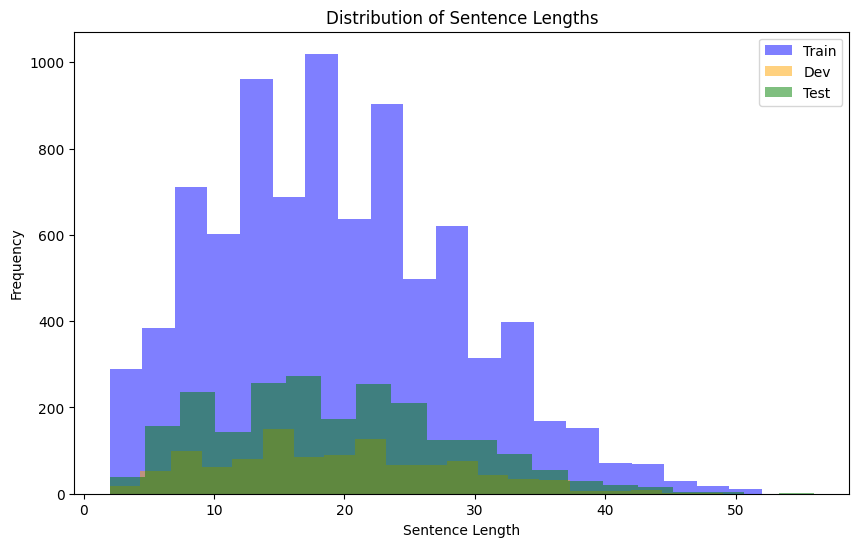

In [54]:
import matplotlib.pyplot as plt

# Calculate sentence lengths for your dataset
def get_sentence_lengths(dataset):
    lengths = [len(example.tokens) for example in dataset]
    return lengths

# Get sentence lengths for train, dev, and test datasets
train_lengths = get_sentence_lengths(train_data)
dev_lengths = get_sentence_lengths(dev_data)
test_lengths = get_sentence_lengths(test_data)

# Plot histograms for each dataset
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=20, alpha=0.5, label='Train', color='blue')
plt.hist(dev_lengths, bins=20, alpha=0.5, label='Dev', color='orange')
plt.hist(test_lengths, bins=20, alpha=0.5, label='Test', color='green')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.show()


In [55]:
import numpy as np

# Compute basic statistics
print("Train dataset:")
print(f"Mean: {np.mean(train_lengths):.2f}, Median: {np.median(train_lengths):.2f}, Std: {np.std(train_lengths):.2f}")
print("Dev dataset:")
print(f"Mean: {np.mean(dev_lengths):.2f}, Median: {np.median(dev_lengths):.2f}, Std: {np.std(dev_lengths):.2f}")
print("Test dataset:")
print(f"Mean: {np.mean(test_lengths):.2f}, Median: {np.median(test_lengths):.2f}, Std: {np.std(test_lengths):.2f}")


Train dataset:
Mean: 19.14, Median: 18.00, Std: 9.31
Dev dataset:
Mean: 19.32, Median: 19.00, Std: 8.86
Test dataset:
Mean: 19.19, Median: 18.00, Std: 8.99


# Tree-LSTM

In the final part of this lab we will exploit the tree structure of the SST data.
Until now we only used the surface tokens, but remember that our data examples include binary trees with a sentiment score at every node.

In particular, we will implement **N-ary Tree-LSTMs** which are described in:

> Kai Sheng Tai, Richard Socher, and Christopher D. Manning. [Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks](http://aclweb.org/anthology/P/P15/P15-1150.pdf) ACL 2015.

Since our trees are binary (i.e., N=2), we can refer to these as *Binary Tree-LSTMs*. If you study equations (9) to (14) in the paper, you will find that they are not all too different from the original LSTM that you already have.

You should read this paper carefully and make sure that you understand the approach. You will also find our LSTM baseline there.
Note however that Tree-LSTMs were proposed around the same time by two other groups:

> Phong Le and Willem Zuidema. [Compositional distributional semantics with long short term memory](http://anthology.aclweb.org/S/S15/S15-1002.pdf). *SEM 2015.

> Xiaodan Zhu, Parinaz Sobihani,  and Hongyu Guo. [Long short-term memory over recursive structures](http://proceedings.mlr.press/v37/zhub15.pdf). ICML 2015.

It is good scientific practice to cite all three papers in your report.




## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this lab? Every example contains a **transition sequence** produced by this function. Let's look at it again:



In [56]:
ex = next(examplereader("trees/dev.txt"))

## Obtaining the transition sequence


In [57]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])

## Coding the Tree-LSTM

The code below contains a Binary Tree-LSTM cell.
It is used in the TreeLSTM class below it, which in turn is used in the TreeLSTMClassifier.
The job of the TreeLSTM class is to encode a complete sentence and return the root node.
The job of the TreeLSTMCell is to return a new state when provided with two children (a reduce action). By repeatedly calling the TreeLSTMCell, the TreeLSTM will encode a sentence. This can be done for multiple sentences at the same time.


#### Exercise
Check the `forward` function and complete the Tree-LSTM formulas.
You can see that we defined a large linear layer for you, that projects the *concatenation* of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.

In [58]:
class TreeLSTMCell(nn.Module):
  """A Binary Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # we concatenate the left and right children
    # you can also project from them separately and then sum
    children = torch.cat([prev_h_l, prev_h_r], dim=1)

    # project the combined children into a 5D tensor for i,fl,fr,g,o
    # this is done for speed, and you could also do it separately
    proj = self.reduce_layer(children)  # shape: B x 5D

    # each shape: B x D
    i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

    # main Tree LSTM computation
    # The shape of each of these is [batch_size, hidden_size]

    # Apply activations
    i = torch.sigmoid(i)          # Input gate
    f_l = torch.sigmoid(f_l)      # Left forget gate
    f_r = torch.sigmoid(f_r)      # Right forget gate
    g = torch.tanh(g)             # Candidate memory
    o = torch.sigmoid(o)          # Output gate

    # Compute the new cell state
    c = i * g + f_l * prev_c_l + f_r * prev_c_r

    # Compute the new hidden state
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

## Explanation of the TreeLSTM class


The code below contains the TreeLSTM class, which implements everything we need in order to encode a sentence from word embeddings. The calculations are the same as in the paper, implemented such that the class `TreeLSTMCell` above is as general as possible and only takes two children to reduce them into a parent.


**Initialize $\mathbf{h}$ and $\mathbf{c}$ outside of the cell for the leaves**

At the leaves of each tree the children nodes are **empty**, whereas in higher levels the nodes are binary tree nodes that *do* have a left and right child (but no input $x$). By initializing the leaf nodes outside of the cell class (`TreeLSTMCell`), we avoid if-else statements in the forward pass.

The `TreeLSTM` class (among other things) pre-calculates an initial $h$ and $c$ for every word in the sentence. Since the initial left and right child are 0, the only calculations we need to do are based on $x$, and we can drop the forget gate calculation (`prev_c_l` and `prev_c_r` are zero). The calculations we do in order to initalize $h$ and $c$ are then:

$$
c_1 =  W^{(u)}x_1 \\
o_1 = \sigma (W^{(i)}x_1) \\
h_1 = o_1 \odot \text{tanh}(c_1)$$
*NB: note that these equations are chosen as initializations of $c$ and $h$, other initializations are possible and might work equally well.*

**Sentence Representations**

All our leaf nodes are now initialized, so we can start processing the sentence in its tree form. Each sentence is represented by a buffer (initially a list with a concatenation of $[h_1, c_1]$ for every word in the reversed sentence), a stack (initially an empty list) and a transition sequence. To encode our sentence, we construct the tree from its transition sequence as explained earlier.

*A short example that constructs a tree:*

We loop over the time dimension of the batched transition sequences (i.e. row by row), which contain values of 0's, 1's and 2's (representing SHIFT, REDUCE and padding respectively). If we have a batch of size 2 where the first example has a transition sequence given by [0, 0, 1, 0, 0, 0, 1] and the second by [0, 0, 1, 0, 0, 1], our transition batch will be given by the following two-dimensional numpy array:

$$
\text{transitions} =
\begin{pmatrix}
0 & 0\\
0 & 0\\
1 & 1\\
0 & 0\\
0 & 0\\
0 & 1\\
1 & 2
\end{pmatrix}
$$
The inner loop (`for transition, buffer, stack in zip(t_batch, buffers, stacks)`) goes over each example in the batch and updates its buffer and stack. The nested loop for this example will then do roughy the following:

```
Time = 0:  t_batch = [0, 0], the inner loop performs 2 SHIFTs.

Time = 1:  t_batch = [0, 0], ".."

Time = 2:  t_batch = [1, 1], causing the inner loop to fill the list child_l and child_r for both examples in the batch. Now the statement if child_l will return True, triggering a REDUCE action to be performed by our Tree LSTM cell with a batch size of 2.

Time = 3:  t_batch = [0, 0], "..".

Time = 4:  t_batch = [0, 0], ".."

Time = 5:  t_batch = [0, 1], one SHIFT will be done and another REDUCE action will be performed by our Tree LSTM, this time of batch size 1.  

Time = 6:  t_batch = [1, 2], triggering another REDUCE action with batch size 1.
```
*NB: note that this was an artificial example for the purpose of demonstrating parts of the code, the transition sequences do not necessarily represent actual trees.*

**Batching and Unbatching**

Within the body of the outer loop over time, we use the functions for batching and unbatching.

*Batching*

Before passing two lists of children to the reduce layer (an instance of `TreeLSTMCell`), we batch the children as they are at this point a list of tensors of variable length based on how many REDUCE actions there are to perform at a certain time step across the batch (let's call the length `L`). To do an efficient forward pass we want to transform the list to a pair of tensors of shape `([L, D], [L, D])`, which the function `batch` achieves.

*Unbatching*

In the same line where we batched the children, we unbatch the output of the forward pass to become a list of states of length `L` again. We do this because we need to loop over each example's transition at the current time step and push the children that are reduced into a parent to the stack.

*The batch and unbatch functions let us switch between the "PyTorch world" (Tensors) and the Python world (easy to manipulate lists).*


In [59]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but
# for processing logic we want to turn the output into lists again
# to easily manipulate.

def batch(states):
  """
  Turns a list of states into a single tensor for fast processing.
  This function also chunks (splits) each state into a (h, c) pair"""
  return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
  """
  Turns a tensor back into a list of states.
  First, (h, c) are merged into a single state.
  Then the result is split into a list of sentences.
  """
  return torch.split(torch.cat(state, 1), 1, 0)

Take some time to understand the class below, having read the explanation above.

In [60]:
class TreeLSTM(nn.Module):
  """Encodes a sentence using a TreeLSTMCell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.reduce = TreeLSTMCell(input_size, hidden_size)

    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)

    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h

    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]

    # t_batch holds 1 transition for each sentence
    for t_batch in transitions:

      child_l = []  # contains the left child for each sentence with reduce action
      child_r = []  # contains the corresponding right child

      # iterate over sentences in the batch
      # each has a transition t, a buffer and a stack
      for transition, buffer, stack in zip(t_batch, buffers, stacks):
        if transition == SHIFT:
          stack.append(buffer.pop())
        elif transition == REDUCE:
          assert len(stack) >= 2, \
            "Stack too small! Should not happen with valid transition sequences"
          child_r.append(stack.pop())  # right child is on top
          child_l.append(stack.pop())

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        for transition, stack in zip(t_batch, stacks):
          if transition == REDUCE:
            stack.append(next(reduced))

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return final

Just like the LSTM before, we will need an extra class that does the classifications.

In [61]:
class TreeLSTMClassifier(nn.Module):
  """Encodes sentence with a TreeLSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(TreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = TreeLSTM(embedding_dim, hidden_dim)
    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):

    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)

    # we use the root/top state of the Tree LSTM to classify the sentence
    root_states = self.treelstm(emb, transitions)

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(root_states)
    return logits

## Special `prepare` function for Tree-LSTM

We need yet another `prepare` function. For our implementation, sentences need to be *reversed*. We will do that here.

In [62]:
def prepare_treelstm_minibatch(mb, vocab):
  """
  Returns sentences reversed (last word first)
  Returns transitions together with the sentences.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  # NOTE: reversed sequence!
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  maxlen_t = max([len(ex.transitions) for ex in mb])
  transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
  transitions = np.array(transitions)
  transitions = transitions.T  # time-major

  return (x, transitions), y

## Training

#### Tree LSTM fixed embeddings


In [63]:
all_bin_accuracies = {}
window_size = 5
max_length = 45
bins = [(max(0, i - window_size // 2), min(max_length, i + window_size // 2)) for i in range(0, max_length + 1)]
bin_ranges = [f"{low}-{high}" for low, high in bins]

# Prepare structure to track bin accuracies for each seed
for bin_range in bin_ranges:
    all_bin_accuracies[bin_range] = []

for seed in seeds:
    set_seed(seed)
    tree_model = TreeLSTMClassifier(
    len(v.w2i), 300, 150, len(t2i), vocab=v)
    with torch.no_grad():
      lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
      lstm_model.embed.weight.requires_grad = False

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

    # Train model
    losses, accuracies, test_acc = train_model(
        model=model,
        optimizer=optimizer,
        num_iterations=1704,
        print_every=250,
        eval_every=250,
        batch_fn=get_examples,
        prep_fn=prepare_example,
        eval_fn=simple_evaluate,
        batch_size=25,
        eval_batch_size=25
    )

    # Evaluate on bins
    binned_data = create_bins(test_data, v)
    bin_accuracies = evaluate_on_bins(model, binned_data, eval_fn=simple_evaluate)

    # Store bin accuracies for this seed
    for bin_range, accuracy in bin_accuracies.items():
        if accuracy is not None:
            all_bin_accuracies[bin_range].append(accuracy)

    print(f"Best Test Accuracy for seed {seed}: {test_acc:.4f}")
    test_accuracies.append(test_acc)

# Compute mean and standard deviation across seeds for overall accuracy
mean_accuracy = np.mean(test_accuracies)
std_accuracy = np.std(test_accuracies)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# Compute mean and standard deviation of bin accuracies
for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:  # Skip bins with no data
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)


Shuffling training data
Iter 250: loss=316.0388, time=0.38s
iter 250: dev acc=0.4205
new highscore
Iter 500: loss=296.7200, time=1.26s
iter 500: dev acc=0.4160
Iter 750: loss=293.9924, time=2.05s
iter 750: dev acc=0.4233
new highscore
Iter 1000: loss=305.2319, time=2.97s
iter 1000: dev acc=0.4187
Iter 1250: loss=325.6496, time=3.91s
iter 1250: dev acc=0.4105
Iter 1500: loss=309.6179, time=4.99s
iter 1500: dev acc=0.4214
Done training
Loading best model


<ipython-input-25-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 750: train acc=0.4552, dev acc=0.4233, test acc=0.4457
Bin 0-2: Metric = 0.5000
Bin 0-3: Metric = 0.8462
Bin 0-4: Metric = 0.3000
Bin 1-5: Metric = 0.5152
Bin 2-6: Metric = 0.4912
Bin 3-7: Metric = 0.4776
Bin 4-8: Metric = 0.5000
Bin 5-9: Metric = 0.6567
Bin 6-10: Metric = 0.3803
Bin 7-11: Metric = 0.4848
Bin 8-12: Metric = 0.3846
Bin 9-13: Metric = 0.4824
Bin 10-14: Metric = 0.3418
Bin 11-15: Metric = 0.5269
Bin 12-16: Metric = 0.4933
Bin 13-17: Metric = 0.4632
Bin 14-18: Metric = 0.4466
Bin 15-19: Metric = 0.5055
Bin 16-20: Metric = 0.4337
Bin 17-21: Metric = 0.3514
Bin 18-22: Metric = 0.3563
Bin 19-23: Metric = 0.3333
Bin 20-24: Metric = 0.4625
Bin 21-25: Metric = 0.4545
Bin 22-26: Metric = 0.3846
Bin 23-27: Metric = 0.5441
Bin 24-28: Metric = 0.3929
Bin 25-29: Metric = 0.3846
Bin 26-30: Metric = 0.4118
Bin 27-31: Metric = 0.3158
Bin 28-32: Metric = 0.4333
Bin 29-33: Metric = 0.5789
Bin 30-34: Metric = 0.4783
Bin 31-35: Metric = 0.3333
Bin 32-36: Metric = 0.3000
Bin 

In [64]:
# Dictionary to store mean bin accuracies
mean_bin_accuracies_tree_lstm = {}

for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)

        # Save the mean accuracy into the dictionary
        mean_bin_accuracies_tree_lstm[bin_range] = mean_bin_acc

#### Tree-LSTMs embeddings tuned

In [65]:
all_bin_accuracies = {}
window_size = 5
max_length = 45
bins = [(max(0, i - window_size // 2), min(max_length, i + window_size // 2)) for i in range(0, max_length + 1)]
bin_ranges = [f"{low}-{high}" for low, high in bins]

# Prepare structure to track bin accuracies for each seed
for bin_range in bin_ranges:
    all_bin_accuracies[bin_range] = []

for seed in seeds:
    set_seed(seed)
    tree_model = TreeLSTMClassifier(
    len(v.w2i), 300, 150, len(t2i), vocab=v)
    with torch.no_grad():
      tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
      tree_model.embed.weight.requires_grad = True

    # Initialize optimizer
    optimizer = torch.optim.Adam(tree_model.parameters(), lr=2e-4)

    # Train model
    losses, accuracies, test_acc = train_model(
        model=model,
        optimizer=optimizer,
        num_iterations=20000,
        print_every=1000,
        eval_every=1000,
        batch_fn=get_examples,
        prep_fn=prepare_example,
        eval_fn=simple_evaluate,
        batch_size=25,
        eval_batch_size=25
    )

    # Evaluate on bins
    binned_data = create_bins(test_data, v)
    bin_accuracies = evaluate_on_bins(model, binned_data, eval_fn=simple_evaluate)

    # Store bin accuracies for this seed
    for bin_range, accuracy in bin_accuracies.items():
        if accuracy is not None:
            all_bin_accuracies[bin_range].append(accuracy)

    print(f"Best Test Accuracy for seed {seed}: {test_acc:.4f}")
    test_accuracies.append(test_acc)

# Compute mean and standard deviation across seeds for overall accuracy
mean_accuracy = np.mean(test_accuracies)
std_accuracy = np.std(test_accuracies)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:  # Skip bins with no data
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)



Shuffling training data
Iter 1000: loss=1256.9199, time=1.32s
iter 1000: dev acc=0.4351
new highscore
Iter 2000: loss=1242.9113, time=3.05s
iter 2000: dev acc=0.4351
Iter 3000: loss=1207.3078, time=4.71s
iter 3000: dev acc=0.4351
Iter 4000: loss=1280.0389, time=6.38s
iter 4000: dev acc=0.4351
Iter 5000: loss=1197.2609, time=8.06s
iter 5000: dev acc=0.4351
Iter 6000: loss=1235.0754, time=10.10s
iter 6000: dev acc=0.4351
Iter 7000: loss=1215.9107, time=12.01s
iter 7000: dev acc=0.4351
Iter 8000: loss=1181.2393, time=13.65s
iter 8000: dev acc=0.4351
Shuffling training data
Iter 9000: loss=1236.8518, time=15.31s
iter 9000: dev acc=0.4351
Iter 10000: loss=1250.3826, time=16.97s
iter 10000: dev acc=0.4351
Iter 11000: loss=1207.0571, time=18.67s
iter 11000: dev acc=0.4351
Iter 12000: loss=1241.8292, time=20.34s
iter 12000: dev acc=0.4351
Iter 13000: loss=1231.4109, time=22.18s
iter 13000: dev acc=0.4351
Iter 14000: loss=1230.7175, time=24.25s
iter 14000: dev acc=0.4351
Iter 15000: loss=1222.7

<ipython-input-25-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 1000: train acc=0.4608, dev acc=0.4351, test acc=0.4566
Bin 0-2: Metric = 0.6667
Bin 0-3: Metric = 0.7692
Bin 0-4: Metric = 0.2500
Bin 1-5: Metric = 0.3939
Bin 2-6: Metric = 0.5439
Bin 3-7: Metric = 0.4776
Bin 4-8: Metric = 0.5102
Bin 5-9: Metric = 0.6866
Bin 6-10: Metric = 0.3521
Bin 7-11: Metric = 0.5303
Bin 8-12: Metric = 0.4615
Bin 9-13: Metric = 0.4706
Bin 10-14: Metric = 0.3165
Bin 11-15: Metric = 0.5054
Bin 12-16: Metric = 0.5200
Bin 13-17: Metric = 0.5053
Bin 14-18: Metric = 0.5146
Bin 15-19: Metric = 0.5165
Bin 16-20: Metric = 0.4096
Bin 17-21: Metric = 0.3649
Bin 18-22: Metric = 0.3908
Bin 19-23: Metric = 0.3763
Bin 20-24: Metric = 0.5375
Bin 21-25: Metric = 0.4394
Bin 22-26: Metric = 0.4615
Bin 23-27: Metric = 0.4853
Bin 24-28: Metric = 0.3750
Bin 25-29: Metric = 0.4038
Bin 26-30: Metric = 0.3824
Bin 27-31: Metric = 0.3684
Bin 28-32: Metric = 0.3667
Bin 29-33: Metric = 0.5263
Bin 30-34: Metric = 0.3913
Bin 31-35: Metric = 0.2778
Bin 32-36: Metric = 0.4500
Bin

In [66]:
# Dictionary to store mean bin accuracies
mean_bin_accuracies_tree_lstm_tuned = {}

# Compute mean and standard deviation of bin accuracies
for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:  # Skip bins with no data
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)

        # Save the mean accuracy into the dictionary
        mean_bin_accuracies_tree_lstm_tuned[bin_range] = mean_bin_acc

# Visualize mean accuracies across sentence lengths

## Including subtrees in graph

In this section, we process the dataset by extracting relevant components required for training a Tree LSTM model. We define an Example structure to represent each data point, which includes the tokens, the tree structure, sentiment labels, and the transitions used for tree reduction.

We then extract subtrees from each tree in the dataset, ensuring that only meaningful subtrees with more than one token are considered. Each subtree is paired with its corresponding sentiment label, which is used as the target for the model.

Finally, we load the training, development, and test datasets using a custom reader function, preparing them for use in the training process. These datasets are stored as lists of examples, ready for model training and evaluation.

##Processing trees

In [68]:
def extract_subtrees(tree_string):
    """
    Recursively extract all subtrees from the given tree string.
    """
    subtrees = []
    stack = []
    current_subtree = []

    for char in tree_string:
        if char == '(':
            # Push current subtree to stack and start a new one
            if current_subtree:
                stack.append(current_subtree)
            current_subtree = []
            current_subtree.append(char)
        elif char == ')':
            # Close the current subtree and add it to the list of subtrees
            current_subtree.append(char)
            subtrees.append(''.join(current_subtree))

            # Pop the previous subtree from stack and continue
            if stack:
                previous_subtree = stack.pop()
                previous_subtree.extend(current_subtree)
                current_subtree = previous_subtree
        else:
            current_subtree.append(char)

    return subtrees

def process_trees(input_file, output_file):
    """
    Read the input file, extract all subtrees from each tree and write to output file.
    """
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            line = line.strip()
            if line:
                subtrees = extract_subtrees(line)
                for subtree in subtrees:
                    outfile.write(subtree + '\n')

input_file = 'trees/train.txt'  # Input file containing the original SST trees
output_file = 'trees/subtrees.txt'  # Output file where each subtree will be written
process_trees(input_file, output_file)
print("Subtrees have been successfully extracted and written to", output_file)


Subtrees have been successfully extracted and written to trees/subtrees.txt


In [69]:
# Print the first 10 lines of the output file
with open(output_file, 'r') as file:
    for i in range(10):
        line = file.readline().strip()

In [70]:
# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])


def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    tree = Tree.fromstring(line)  # use NLTK's Tree
    label = int(line[1])
    trans = transitions_from_treestring(line)
    yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)


# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/subtrees.txt", lower=LOWER))

In [ ]:
len(train_data)

From the size of the training data, use 100 batches therefore to pass 10 epochs, iterations need to be 33000

In [79]:
all_bin_accuracies = {}
test_accuracies = []
window_size = 5
max_length = 45
bins = [(max(0, i - window_size // 2), min(max_length, i + window_size // 2)) for i in range(0, max_length + 1)]
bin_ranges = [f"{low}-{high}" for low, high in bins]

# Prepare structure to track bin accuracies for each seed
for bin_range in bin_ranges:
    all_bin_accuracies[bin_range] = []

for seed in seeds:
    set_seed(seed)
    tree_model = TreeLSTMClassifier(
    len(v.w2i), 300, 150, len(t2i), vocab=v)
    with torch.no_grad():
      tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
      tree_model.embed.weight.requires_grad = True

    # Initialize optimizer
    optimizer = torch.optim.Adam(tree_model.parameters(), lr=2e-4)

    # Train model
    losses, accuracies, test_acc = train_model(
        model=model,
        optimizer=optimizer,
        num_iterations=15930,
        print_every=1000,
        eval_every=1000,
        batch_fn=get_examples,
        prep_fn=prepare_example,
        eval_fn=simple_evaluate,
        batch_size=100,
        eval_batch_size=100
    )

    # Evaluate on bins
    binned_data = create_bins(test_data, v)
    bin_accuracies = evaluate_on_bins(model, binned_data, eval_fn=simple_evaluate)

    # Store bin accuracies for this seed
    for bin_range, accuracy in bin_accuracies.items():
        if accuracy is not None:
            all_bin_accuracies[bin_range].append(accuracy)

    print(f"Best Test Accuracy for seed {seed}: {test_acc:.4f}")
    test_accuracies.append(test_acc)

# Compute mean and standard deviation across seeds for overall accuracy
mean_accuracy = np.mean(test_accuracies)
std_accuracy = np.std(test_accuracies)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# Compute mean and standard deviation of bin accuracies
for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:  # Skip bins with no data
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)

Shuffling training data
Iter 1000: loss=1536.8234, time=1.47s
iter 1000: dev acc=0.4351
new highscore
Iter 2000: loss=1544.0778, time=3.60s
iter 2000: dev acc=0.4351
Iter 3000: loss=1547.0044, time=5.56s
iter 3000: dev acc=0.4351
Iter 4000: loss=1554.6468, time=7.20s
iter 4000: dev acc=0.4351
Iter 5000: loss=1568.6283, time=8.87s
iter 5000: dev acc=0.4351
Iter 6000: loss=1538.7983, time=10.56s
iter 6000: dev acc=0.4351
Iter 7000: loss=1555.0954, time=12.24s
iter 7000: dev acc=0.4351
Iter 8000: loss=1554.0163, time=13.90s
iter 8000: dev acc=0.4351
Iter 9000: loss=1540.7953, time=15.79s
iter 9000: dev acc=0.4351
Iter 10000: loss=1565.3584, time=17.90s
iter 10000: dev acc=0.4351
Iter 11000: loss=1560.8487, time=19.55s
iter 11000: dev acc=0.4351
Iter 12000: loss=1545.3802, time=21.22s
iter 12000: dev acc=0.4351
Iter 13000: loss=1545.8586, time=22.88s
iter 13000: dev acc=0.4351
Iter 14000: loss=1571.5275, time=24.54s
iter 14000: dev acc=0.4351
Iter 15000: loss=1560.9925, time=26.20s
iter 15

<ipython-input-25-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 1000: train acc=0.2061, dev acc=0.4351, test acc=0.4566
Bin 0-2: Metric = 0.6667
Bin 0-3: Metric = 0.7692
Bin 0-4: Metric = 0.2500
Bin 1-5: Metric = 0.3939
Bin 2-6: Metric = 0.5439
Bin 3-7: Metric = 0.4776
Bin 4-8: Metric = 0.5102
Bin 5-9: Metric = 0.6866
Bin 6-10: Metric = 0.3521
Bin 7-11: Metric = 0.5303
Bin 8-12: Metric = 0.4615
Bin 9-13: Metric = 0.4706
Bin 10-14: Metric = 0.3165
Bin 11-15: Metric = 0.5054
Bin 12-16: Metric = 0.5200
Bin 13-17: Metric = 0.5053
Bin 14-18: Metric = 0.5146
Bin 15-19: Metric = 0.5165
Bin 16-20: Metric = 0.4096
Bin 17-21: Metric = 0.3649
Bin 18-22: Metric = 0.3908
Bin 19-23: Metric = 0.3763
Bin 20-24: Metric = 0.5375
Bin 21-25: Metric = 0.4394
Bin 22-26: Metric = 0.4615
Bin 23-27: Metric = 0.4853
Bin 24-28: Metric = 0.3750
Bin 25-29: Metric = 0.4038
Bin 26-30: Metric = 0.3824
Bin 27-31: Metric = 0.3684
Bin 28-32: Metric = 0.3667
Bin 29-33: Metric = 0.5263
Bin 30-34: Metric = 0.3913
Bin 31-35: Metric = 0.2778
Bin 32-36: Metric = 0.4500
Bin

In [72]:
# Dictionary to store mean bin accuracies
mean_bin_accuracies_tree_lstm_sub = {}

# Compute mean and standard deviation of bin accuracies
for bin_range, accuracies in all_bin_accuracies.items():
    if accuracies:  # Skip bins with no data
        mean_bin_acc = np.mean(accuracies)
        std_bin_acc = np.std(accuracies)

        # Save the mean accuracy into the dictionary
        mean_bin_accuracies_tree_lstm_sub[bin_range] = mean_bin_acc


## Plotting trees

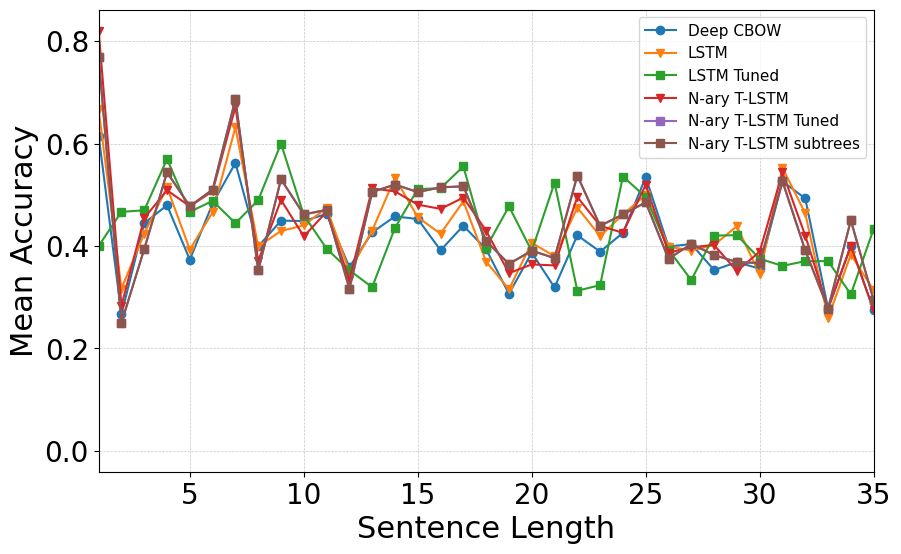

In [101]:
# Extract bin ranges and accuracies
bin_ranges = list(mean_bin_accuracies_lstm.keys())
dcbow_accuracies = list(mean_bin_accuracies_dcbow.values())
lstm_accuracies = list(mean_bin_accuracies_lstm.values())
lstm_tuned_accuracies = list(mean_bin_accuracies_lstm_tuned.values())
tree_lstm_accuracies = list(mean_bin_accuracies_tree_lstm.values())
tree_lstm_tuned_accuracies = list(mean_bin_accuracies_tree_lstm_tuned.values())
tree_lstm_sub_accuracies = list(mean_bin_accuracies_tree_lstm_sub.values())


bins = [(0, 2), (0, 3), (0, 4), (1, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 10),
        (7, 11), (8, 12), (9, 13), (10, 14), (11, 15), (12, 16), (13, 17),
        (14, 18), (15, 19), (16, 20), (17, 21), (18, 22), (19, 23), (20, 24),
        (21, 25), (22, 26), (23, 27), (24, 28), (25, 29), (26, 30), (27, 31),
        (28, 32), (29, 33), (30, 34), (31, 35), (32, 36), (33, 37), (34, 38),
        (35, 39), (36, 40), (37, 41), (38, 42), (39, 43), (40, 44), (41, 45),
        (42, 46), (43, 47)]

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(bin_ranges, dcbow_accuracies, marker='o', label='Deep CBOW')
plt.plot(bin_ranges, lstm_accuracies, marker='v', label='LSTM')
plt.plot(bin_ranges, lstm_tuned_accuracies, marker='s', label='LSTM Tuned')
plt.plot(bin_ranges, tree_lstm_accuracies, marker = 'v', label = 'N-ary T-LSTM')
plt.plot(bin_ranges, tree_lstm_tuned_accuracies, marker = 's', label = 'N-ary T-LSTM Tuned')
plt.plot(bin_ranges, tree_lstm_sub_accuracies, marker = 's', label = 'N-ary T-LSTM subtrees')


# Set x-tick positions and labels
tick_positions = list(range(0, len(bins), 5))
tick_labels = [str(i) for i in range(0, len(tick_positions) * 5, 5)]
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.xticks(tick_positions, tick_labels)

# Add labels, legend, and title
plt.xlabel("Sentence Length", fontsize=22)
plt.xlim(1, 35)
plt.ylabel("Mean Accuracy", fontsize=22)
plt.legend(loc='upper right', fontsize=11, frameon=True)

# Add gridlines for better readability
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

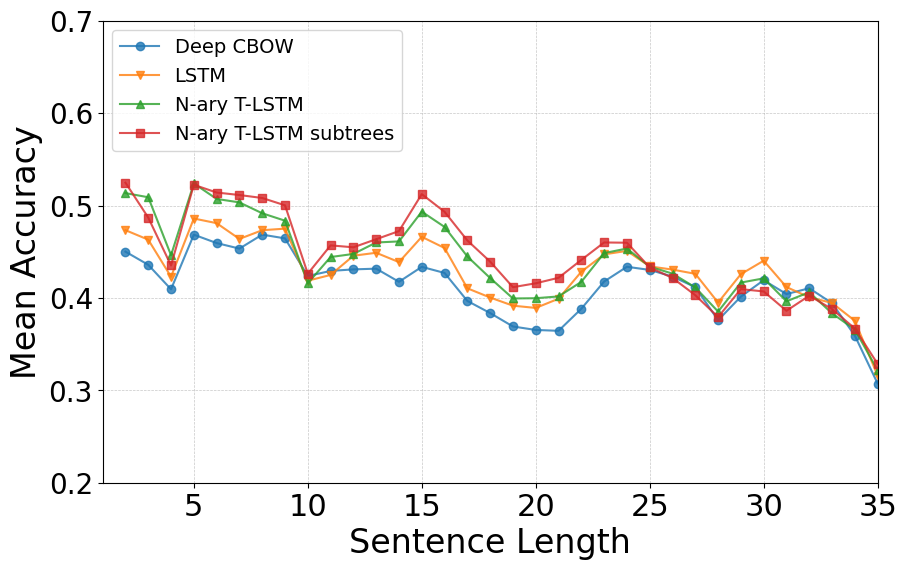

In [93]:
# Convert accuracies into pandas Series for rolling mean calculation
dcbow_series = pd.Series(dcbow_accuracies)
lstm_series = pd.Series(lstm_accuracies)
tree_lstm_series = pd.Series(tree_lstm_accuracies)
tree_lstm_sub_series = pd.Series(tree_lstm_sub_accuracies)


# Apply rolling mean (window size = 5)
window_size = 5
dcbow_smoothed = dcbow_series.rolling(window=window_size, center=True).mean()
lstm_smoothed = lstm_series.rolling(window=window_size, center=True).mean()
tree_lstm_smoothed = tree_lstm_series.rolling(window=window_size, center=True).mean()
tree_lstm_sub_smoothed = tree_lstm_sub_series.rolling(window=window_size, center=True).mean()


# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(bin_ranges, dcbow_smoothed, marker='o', label='Deep CBOW', linestyle='-', alpha=0.8)
plt.plot(bin_ranges, lstm_smoothed, marker='v', label='LSTM', linestyle='-', alpha=0.8)
plt.plot(bin_ranges, tree_lstm_smoothed, marker='^', label='N-ary T-LSTM', linestyle='-', alpha=0.8)
plt.plot(bin_ranges, tree_lstm_sub_smoothed, marker='s', label='N-ary T-LSTM subtrees',linestyle='-', alpha=0.8)

# Set x-tick positions and labels
tick_positions = list(range(0, len(bins), 5))
tick_labels = [str(i) for i in range(0, len(tick_positions) * 5, 5)]
plt.yticks(fontsize=20)
plt.xticks(tick_positions, tick_labels, fontsize =22)

# Add labels, legend, and title
plt.xlabel("Sentence Length", fontsize=24)
plt.xlim(1, 35)
plt.ylim(0.2, 0.7)
plt.ylabel("Mean Accuracy", fontsize=24)
plt.legend(loc='upper left', fontsize=14, frameon=True)

# Add gridlines for better readability
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()
